# Sistemas Biometricos

## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from wfdb import rdsamp
from os import listdir
from biosppy.signals import ecg
from biosppy.clustering import outliers_dmean

## Load Data

###  Dataset - ECG ID 

In [13]:
dataset_path = "../../data/ecg_id" # path to the dataset
person_path = '{}/Person_{:02}'
record_path = '{}/rec_{}'
numb_persons = 90

def get_numb_records(path) -> int: 
    repeat = 3 # number of files per record
    numb_of_files = len(listdir(path))
    return int(numb_of_files/repeat) 

def load_data(path):
    paths = [(person_path.format(dataset_path, i+1), i) for i in range(0, numb_persons)] # or [1,2,4]
    data = [
        (rdsamp(record_path.format(path, r)), p) 
                for path, p in paths 
                    for r in range(1, get_numb_records(path) + 1) # or [1,2,3]
    ]
    train = []
    test = []
    for i in range(len(data)):
        if i % 2 == 0:
            train.append(data[i])
        else:
            test.append(data[i])

    numb_persons_train = len(np.unique([d[1] for d in train]))
    numb_persons_test = len(np.unique([d[1] for d in test]))

    return train, test, numb_persons_train, numb_persons_test

data_train, data_test, numb_persons_train, numb_persons_test = load_data(dataset_path.format(1))


In [15]:
signal, fields  = data_train[0][0]
raw_data_train = [(s[:,0], p) for ((s,f), p) in data_train]
filtered_data_train = [(s[:,1], p) for ((s,f), p) in data_train]
raw_data_test = [(s[:,0], p) for ((s,f), p) in data_test]
filtered_data_test = [(s[:,1], p) for ((s,f), p) in data_test]
fs = fields['fs'] # frequency

###  Dataset - Alunos


In [4]:
dataset_path = "../../data/SB_ECGDatabase_0{}" # path to the dataset

def load_data(dataset_path):
    records = listdir(dataset_path)
    numb_persons = len(records)
    data = [
        (np.loadtxt('{}/{}'.format(dataset_path, record)), 
         int(record.split('_u')[1].split('.')[0])) 
                 for record in records
    ]
    return data, numb_persons

data_train, numb_persons_train = load_data(dataset_path.format(1))
data_test, numb_persons_test = load_data(dataset_path.format(2))

In [ ]:
signal = data_train[0][0]
raw_data_train = [(s[:,1], p) for (s, p) in data_train]
raw_data_test = [(s[:,1], p) for (s, p) in data_test]
filtered_data_train = []
fs = 1000

## Data Visualization

In [16]:
table_header = ['','Number of Persons', 'FS (hz)', 'Sample time (sec)']
table_data = [
    ['Train', numb_persons_train, fs, raw_data_train[0][0].shape[0]/fs],
    ['Test', numb_persons_test, fs, raw_data_test[0][0].shape[0]/fs],
]

table_string = tabulate(table_data, headers=table_header, tablefmt="grid")

print(table_string )

+-------+---------------------+-----------+---------------------+
|       |   Number of Persons |   FS (hz) |   Sample time (sec) |
+=======+=====================+===========+=====================+
| Train |                  90 |       500 |                  20 |
+-------+---------------------+-----------+---------------------+
| Test  |                  89 |       500 |                  20 |
+-------+---------------------+-----------+---------------------+


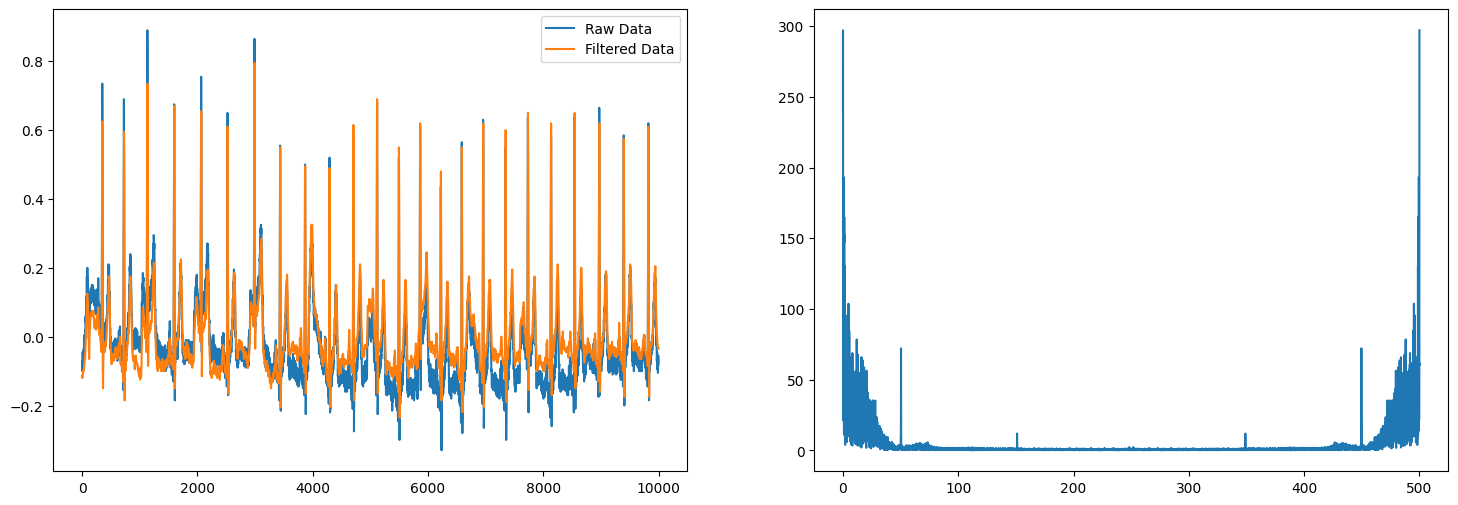

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(raw_data_train[0][0], label='Raw Data') 
if len(filtered_data_train) > 0:
    axes[0].plot(filtered_data_train[0][0], label='Filtered Data')
axes[0].legend()

X = np.fft.fft(raw_data_train[0][0])
freq = np.arange(len(X))/len(X)*fs
axes[1].plot(freq,np.abs(np.abs(X)))


plt.show()

## BioSppy

In [21]:
def get_templates(raw_data, fs):
    outs = [ (ecg.ecg(signal=s, sampling_rate=fs, show=False), p) for ((s), p) in raw_data]
    return outs

outs_tain = get_templates(raw_data_train, fs)
outs_test = get_templates(raw_data_test, fs)

### Templates

In [22]:
def parse_outs(outs):
    labels = np.hstack([p for out, p in outs for _ in range(out["templates"].shape[0])])
    templates = np.vstack([ out["templates"] for out, _ in outs])
    return (templates, labels)


templates_tain, labels_tain = parse_outs(outs_tain)
templates_test, labels_test = parse_outs(outs_test)

In [23]:
table_header = ['','Number of templates','Number of features', 'Number of labels']
table_data = [
    ['Train', templates_tain.shape[0], templates_tain.shape[1], labels_tain.shape[0]],
    ['Test', templates_test.shape[0], templates_test.shape[1], labels_test.shape[0]],
]

table_string = tabulate(table_data, headers=table_header, tablefmt="grid")

print(table_string )

+-------+-----------------------+----------------------+--------------------+
|       |   Number of templates |   Number of features |   Number of labels |
+=======+=======================+======================+====================+
| Train |                  3922 |                  300 |               3922 |
+-------+-----------------------+----------------------+--------------------+
| Test  |                  3934 |                  300 |               3934 |
+-------+-----------------------+----------------------+--------------------+


### View Templates person

(29, 300)


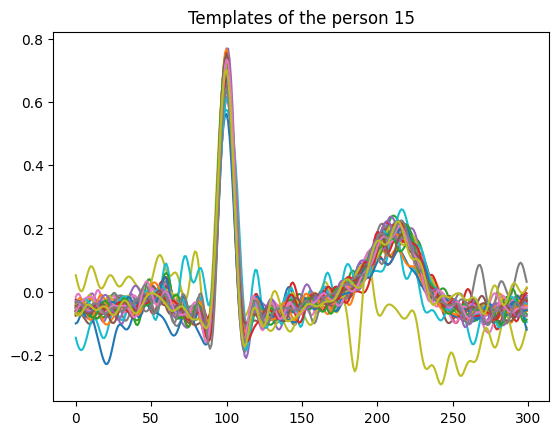

In [33]:
person_number = 15 #13
templates_person = templates_tain[labels_tain == person_number]

print(templates_person.shape)

plt.plot(templates_person.T)
plt.title('Templates of the person {}'.format(person_number))
plt.show()

## Outlier Detection

In [34]:


def remove_outliers(templates, labels, alpha = 0.5, beta = 1.5):
    unique_labels = np.unique(labels)
    new_labels = np.array([])
    new_labels_out = np.array([])
    new_templates = []
    new_templates_out = []
    for l in unique_labels:
        temp = templates[labels == l] # templates de um label
        out = outliers_dmean(data=temp, alpha=alpha, beta=beta) # detectar outliers D-Mean 
        idx = out['clusters'][0] # indices dos templates que não são outliers
        idx_out = out['clusters'][-1] # indices dos templates que são outliers
        new_labels = np.hstack((new_labels, labels[labels == l][idx]))
        new_labels_out = np.hstack((new_labels_out, labels[labels == l][idx_out]))
        new_templates.append(temp[idx])
        new_templates_out.append(temp[idx_out])
        
    new_templates = np.vstack(new_templates)
    new_templates_out = np.vstack(new_templates_out)
    return (new_templates, new_labels, new_templates_out, new_labels_out)



templates_test, labels_test = parse_outs(outs_test)
templates_tain_out, labels_tain_out, templates_tain_out_removed, labels_tain_out_removed = remove_outliers(templates_tain, labels_tain)
templates_test_out, labels_test_out, templates_test_out_removed, labels_test_out_removed = remove_outliers(templates_test, labels_test)

In [35]:
table_header = ['','Number of templates','Number of features', 'Number of labels']
table_data = [
    ['Train', templates_tain_out.shape[0], templates_tain_out.shape[1], labels_tain_out.shape[0]],
    ['Test', templates_test_out.shape[0], templates_test_out.shape[1], labels_test_out.shape[0]],
]

table_string = tabulate(table_data, headers=table_header, tablefmt="grid")

print(table_string )

+-------+-----------------------+----------------------+--------------------+
|       |   Number of templates |   Number of features |   Number of labels |
+=======+=======================+======================+====================+
| Train |                  3016 |                  300 |               3016 |
+-------+-----------------------+----------------------+--------------------+
| Test  |                  3089 |                  300 |               3089 |
+-------+-----------------------+----------------------+--------------------+


#### Test Outlier Detection

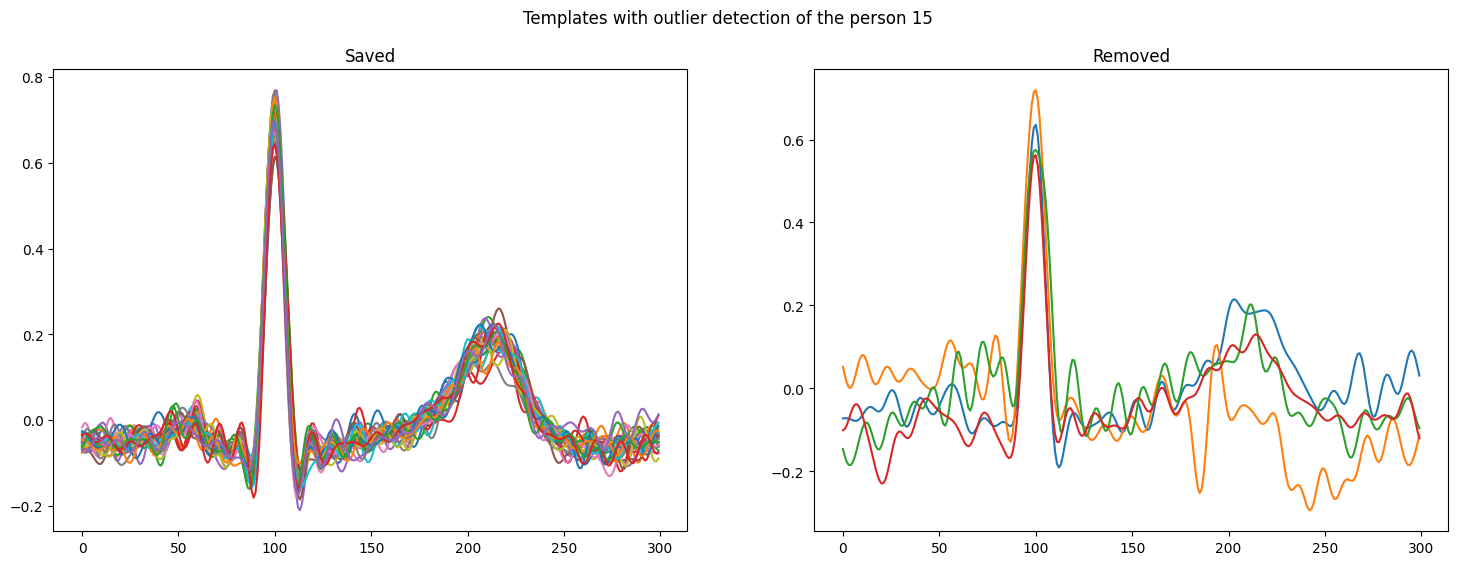

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


axes[0].set_title('Saved')
axes[0].plot(templates_tain_out[labels_tain_out == person_number].T)

axes[1].set_title('Removed')
axes[1].plot(templates_tain_out_removed[labels_tain_out_removed == person_number].T)

plt.suptitle('Templates with outlier detection of the person {}'.format(person_number))
plt.show()


## Load Balance

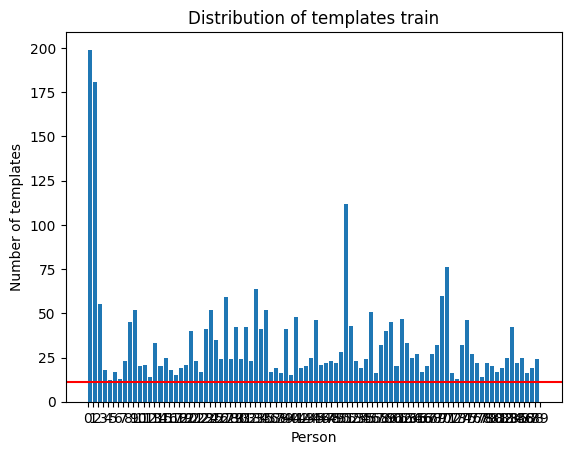

In [49]:
percentage = 0.95
labels_train, labels_count = np.unique(labels_tain_out, return_counts=True)
nTemplates_train = round(labels_count.min() * percentage)

plt.title('Distribution of templates train')
plt.xlabel('Person')
plt.ylabel('Number of templates')
plt.xticks(ticks=labels_train)
plt.axhline(y=nTemplates_train, color='r', label=f'Number min of templates {nTemplates_train}')
plt.hist(labels_tain_out, bins=numb_persons_train, rwidth=0.8)
plt.show()

## Template Selection

In [50]:
from biosppy.clustering import mdist_templates


def template_selection(templates, labels, nTemplates=None, metric = 'euclidean', percentage = 0.9):
    unique_labels = np.unique(labels)
    new_labels_sel = np.array([])
    new_templates_sel = []

    for l in unique_labels:
        temp = templates[labels == l]
        if nTemplates is None:
            nTemplates = round(temp.shape[0] * percentage) 
        out = mdist_templates(data=temp, ntemplates=nTemplates, metric=metric) # template selection m_dist
        new_templates_sel.append(out['templates'])
        new_labels = np.ones(len(out['templates']))*l
        new_labels_sel = np.hstack((new_labels_sel, new_labels))
        
    new_templates_sel = np.vstack(new_templates_sel)
    return (new_templates_sel, new_labels_sel)

templates_tain_sel, labels_tain_sel = template_selection(templates_tain_out, labels_tain_out, nTemplates=nTemplates_train)
templates_test_sel, labels_test_sel = template_selection(templates_test_out, labels_test_out, percentage=percentage)

In [51]:
table_header = ['','Number of templates','Number of features', 'Number of labels']
table_data = [
    ['Train', templates_tain_sel.shape[0], templates_tain_sel.shape[1], labels_tain_sel.shape[0]],
    ['Test', templates_test_sel.shape[0], templates_test_sel.shape[1], labels_test_sel.shape[0]],
]

table_string = tabulate(table_data, headers=table_header, tablefmt="grid")

print(table_string )

+-------+-----------------------+----------------------+--------------------+
|       |   Number of templates |   Number of features |   Number of labels |
+=======+=======================+======================+====================+
| Train |                   990 |                  300 |                990 |
+-------+-----------------------+----------------------+--------------------+
| Test  |                  3038 |                  300 |               3038 |
+-------+-----------------------+----------------------+--------------------+


#### Test Template Selection

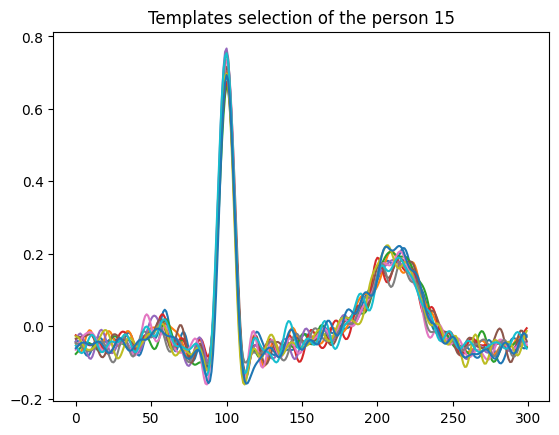

In [52]:
plt.title('Templates selection of the person {}'.format(person_number))
plt.plot(templates_tain_sel[labels_tain_sel == person_number].T)
plt.show()

## Train & Test

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

X_train, y_train = templates_tain_sel, labels_tain_sel
X_test, y_test = templates_test_sel, labels_test_sel
n = 5

folds = StratifiedShuffleSplit(n_splits=n, test_size=0.2, random_state=0)

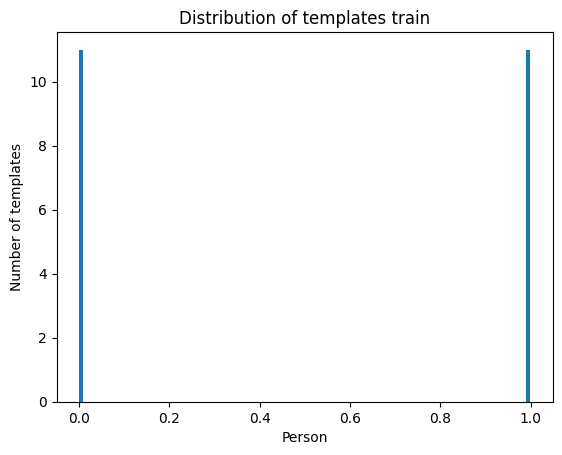

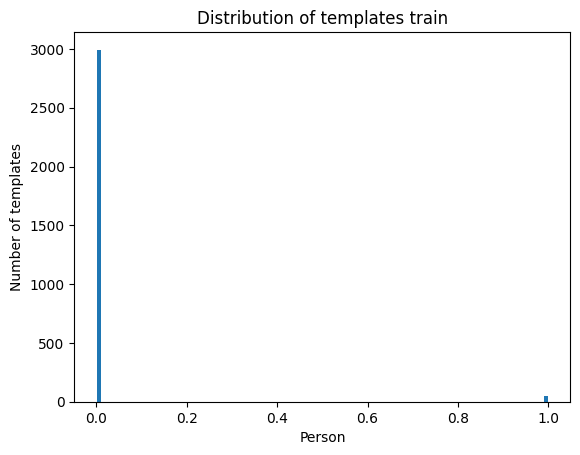

In [54]:
from imblearn.under_sampling import RandomUnderSampler
person = 2  #person_number

labels_names = np.unique(y_train)

y_train_bin = y_train.copy()
y_train_bin[y_train == person] = 1
y_train_bin[y_train != person] = 0
y_test_bin = y_test.copy()
y_test_bin[y_test == person] = 1
y_test_bin[y_test != person] = 0

X_train_bin, y_train_bin = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train_bin)


labels_names = np.unique(y_train)

plt.title('Distribution of templates train')
plt.xlabel('Person')
plt.ylabel('Number of templates')
plt.hist(y_train_bin, bins=numb_persons_train, rwidth=0.8)
plt.show()

plt.title('Distribution of templates train')
plt.xlabel('Person')
plt.ylabel('Number of templates')
plt.hist(y_test_bin, bins=numb_persons_test, rwidth=0.8)
plt.show()



In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

def print_scores(grid_search,X, y, binary=False):
    print("Best parameters found: ", grid_search.best_params_)
    print("Validation accuracy score: {:.2f}".format(grid_search.best_score_))
    
    model = grid_search.best_estimator_
    y_pred = model.predict(X)
    labels_names = np.unique(y)

    print(np.unique(y_pred))
    print(labels_names)

    print(classification_report(y, y_pred, zero_division=0, labels= labels_names))

    disp = ConfusionMatrixDisplay(confusion_matrix(y, y_pred))
    disp.plot()

    if len(labels_names) == 2:
        y_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

## KNN

### Multiclass

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3}
Validation accuracy score: 0.98
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 74. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95       174
         1.0       0.90      0.91      0.91       174
         2.0       0.75

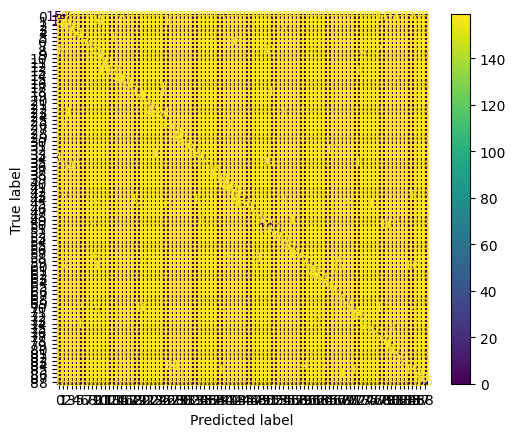

In [56]:
from sklearn.neighbors import KNeighborsClassifier

parameters  = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, cv=folds)

grid_search.fit(X_train, y_train)

knnModel = grid_search.best_estimator_

print_scores(grid_search, X_test, y_test)


#### Binary

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3}
Validation accuracy score: 0.96
[0. 1.]
[0. 1.]
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90      2993
         1.0       0.08      1.00      0.15        45

    accuracy                           0.83      3038
   macro avg       0.54      0.91      0.52      3038
weighted avg       0.99      0.83      0.89      3038



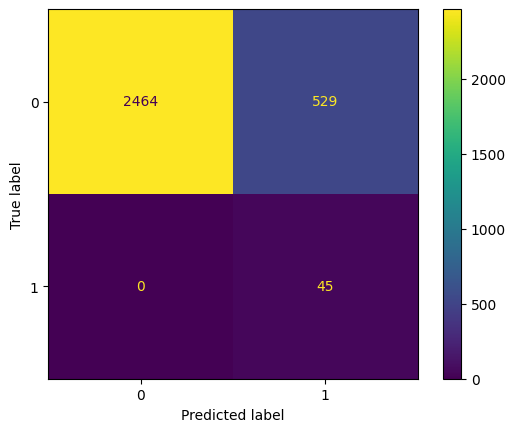

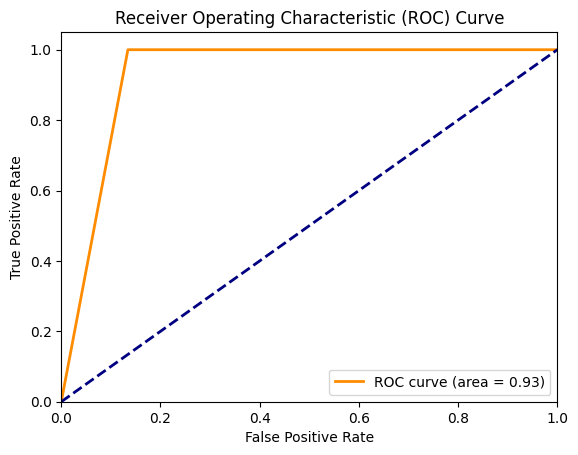

In [57]:
parameters  = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, cv=folds)

grid_search.fit(X_train_bin, y_train_bin)

knnModel = grid_search.best_estimator_

print_scores(grid_search, X_test, y_test_bin)


## SVM

#### Multiclass

Best parameters found:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Validation accuracy score: 1.00
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 74. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90       174
         1.0       0.93      0.90      0.92       174
         2.0       1.00

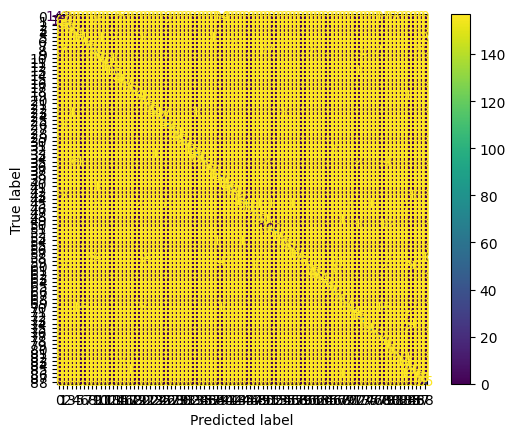

In [58]:
from sklearn.svm import SVC

parameters  = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

svm = SVC(probability=True)
grid_search = GridSearchCV(svm, parameters, cv=folds)

grid_search.fit(X_train, y_train)

svmModel = grid_search.best_estimator_

print_scores(grid_search, X_test, y_test)

#### Binary

Best parameters found:  {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Validation accuracy score: 0.96
[0. 1.]
[0. 1.]
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93      2993
         1.0       0.11      0.98      0.19        45

    accuracy                           0.88      3038
   macro avg       0.55      0.93      0.56      3038
weighted avg       0.99      0.88      0.92      3038



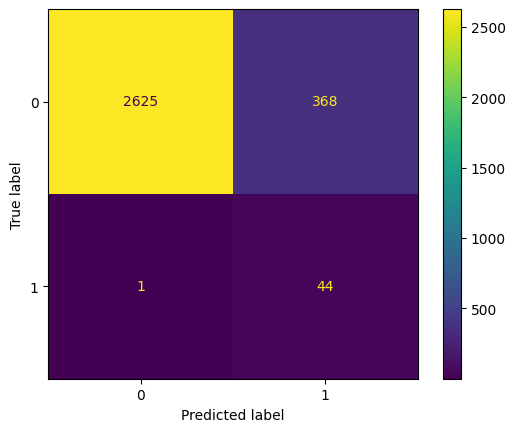

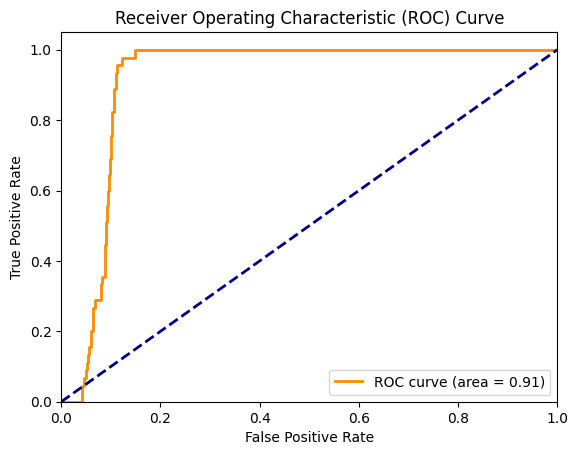

In [59]:
from sklearn.svm import SVC

parameters  = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

svm = SVC(probability=True)
grid_search = GridSearchCV(svm, parameters, cv=folds)

grid_search.fit(X_train_bin, y_train_bin)

svmModel = grid_search.best_estimator_

print_scores(grid_search, X_test, y_test_bin)

## SVM VS Rest

#### Multiclass

Best parameters found:  {}
Validation accuracy score: 0.97
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92       174
         1.0       0.94      0.95      0.95       174
         2.0       0.81      0.56      0.66       

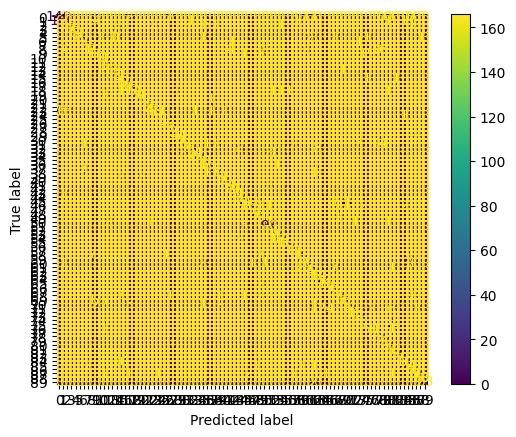

In [60]:
from sklearn.multiclass import OneVsRestClassifier

parameters  = {}

svm = SVC(C=1, gamma=1, kernel='linear')
ovr = OneVsRestClassifier(svm)
grid_search = GridSearchCV(ovr, parameters, cv=folds)

grid_search.fit(X_train, y_train)

svmModel = grid_search.best_estimator_

print_scores(grid_search, X_test, y_test)

Best parameters found:  {}
Validation accuracy score: 0.96
[0. 1.]
[0. 1.]
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      2993
         1.0       0.08      1.00      0.16        45

    accuracy                           0.84      3038
   macro avg       0.54      0.92      0.53      3038
weighted avg       0.99      0.84      0.90      3038



AttributeError: This 'OneVsRestClassifier' has no attribute 'predict_proba'

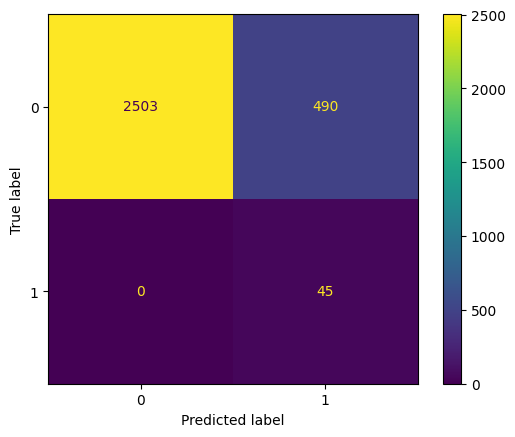

In [61]:
from sklearn.multiclass import OneVsRestClassifier

parameters  = {}

svm = SVC(C=1, gamma=1, kernel='linear')
ovr = OneVsRestClassifier(svm)
grid_search = GridSearchCV(ovr, parameters, cv=folds)
grid_search.fit(X_train_bin, y_train_bin)

svmModel = grid_search.best_estimator_

print_scores(grid_search, X_test, y_test_bin)

Accuracy:  0.9603174603174603
Accuracy:  0.9576719576719577


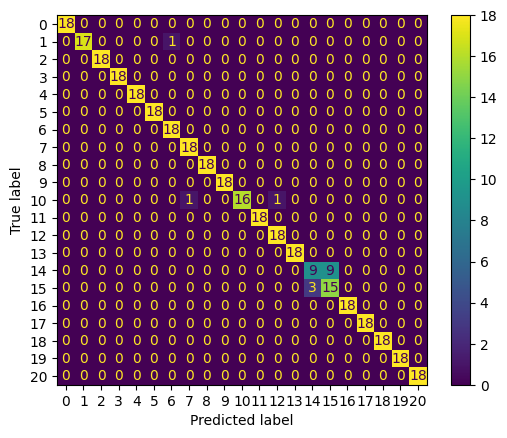

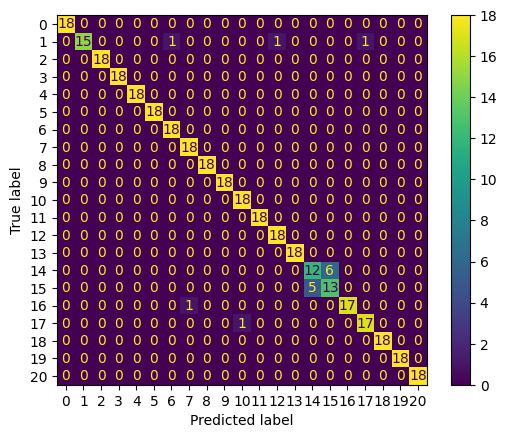

In [ ]:


for X_train, y_train, X_test, y_test in data_train:
    svm = SVC(C=10, kernel='rbf')
    clf = OneVsRestClassifier(svm).fit(X_train, y_train)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_scores(y_test, y_pred)

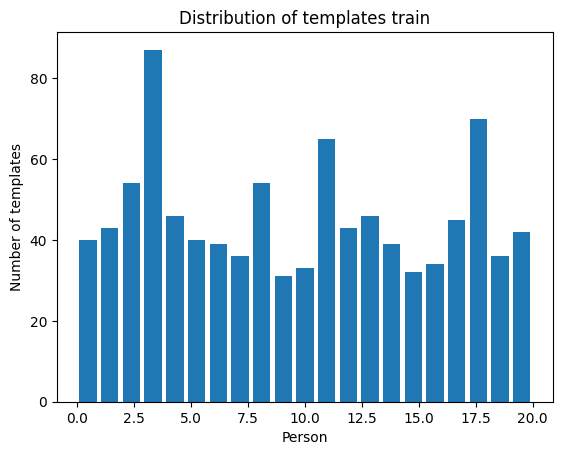

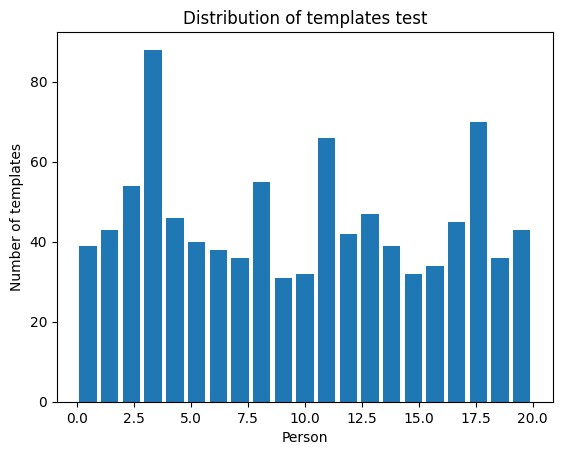

Accuracy: 0.79
Accuracy: 0.86
Accuracy: 0.83


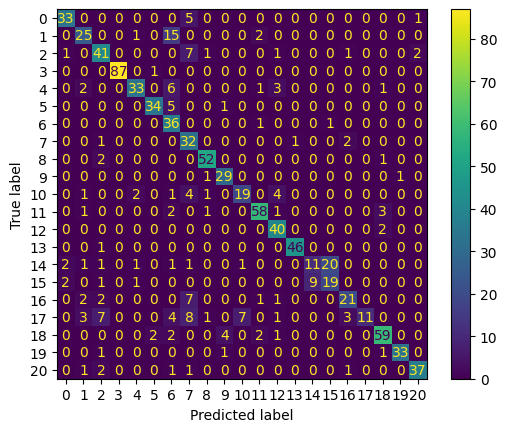

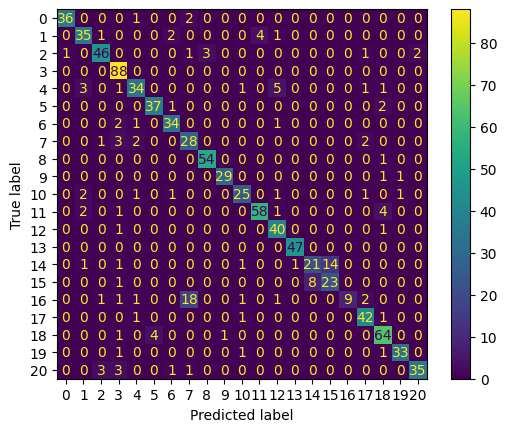

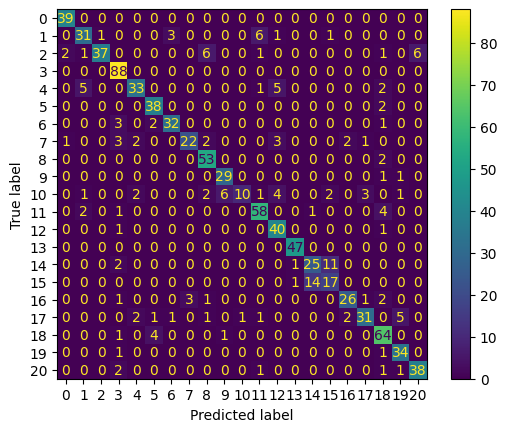

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import SVC


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(templates, labels)):
    X_train = templates[train_index]
    X_test = templates[test_index]
    y_train = labels[train_index]
    y_test = labels[test_index]
    #y_train[y_train != 5] = 0
    #y_test[y_test != 5] = 0

    plt.title('Distribution of templates train')
    plt.xlabel('Person')
    plt.ylabel('Number of templates')
    plt.hist(y_train, bins=numb_persons, rwidth=0.8)
    plt.show()

    plt.title('Distribution of templates test')
    plt.xlabel('Person')
    plt.ylabel('Number of templates')
    plt.hist(y_test, bins=numb_persons, rwidth=0.8)
    plt.show()

    
    knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #precision = precision_score(y_test, y_pred)
    #recall = recall_score(y_test, y_pred)
    #f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    #print(f"Precision: {precision:.2f}")
    #print(f"Recall: {recall:.2f}")
    #print(f"F1 Score: {f1:.2f}")

    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.plot()
    

    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #precision = precision_score(y_test, y_pred)
    #recall = recall_score(y_test, y_pred)
    #f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    #print(f"Precision: {precision:.2f}")
    #print(f"Recall: {recall:.2f}")
    #print(f"F1 Score: {f1:.2f}")

    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.plot()

    clf = OneVsRestClassifier(SVC()).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.plot()
    




IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

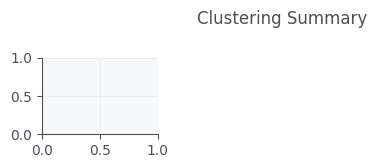

In [112]:
from biosppy.plotting import plot_clustering
from biosppy.plotting import plot_clustering

dic = np.zeros(templates_person.shape[0])

//s_temp = plot_clustering(data=templates_person,clusters=dic, show=True)


In [20]:
from biosppy.clustering import consensus_kmeans

dic = consensus_kmeans(data=templates_person, k = numb_persons)


c:\Python310\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [21]:
print(len(res[0]))
print(res[0])

NameError: name 'res' is not defined

150


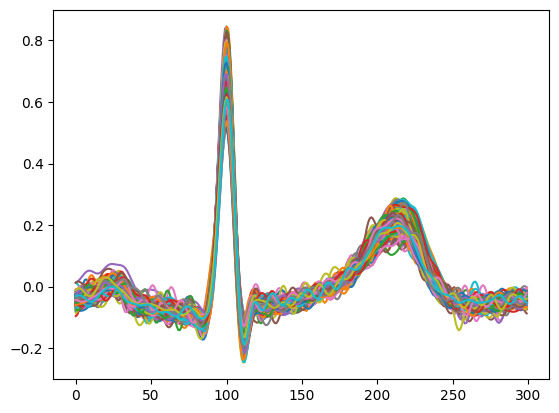

In [28]:
from biosppy.clustering import mdist_templates

templates_person = templates[labels <= 3]
res = mdist_templates(data=templates_person,  clusters=dic[0],  ntemplates=150)

print(len(res[0]))

plt.plot(res[0].T)
plt.show()

## Data Analysis  

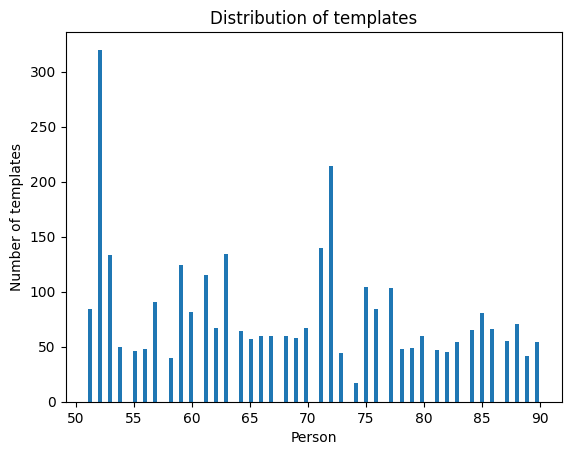

In [12]:
plt.title('Distribution of templates')
plt.xlabel('Person')
plt.ylabel('Number of templates')
plt.hist(labels[labels>50], bins=numb_persons, rwidth=0.8)
plt.show()


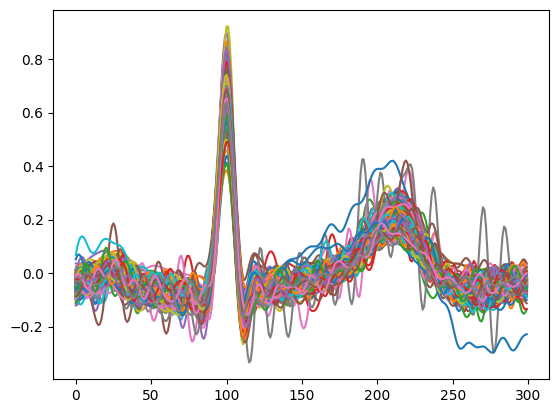

In [74]:
plt.plot(templates_person.T)
plt.show()

ValueError: need at least one array to concatenate

(86, 86)


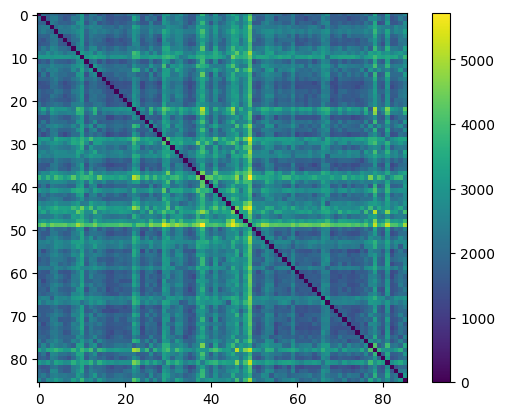

In [51]:
from scipy.spatial import distance
m = distance.cdist(templates_person, templates_person, 'euclidean')
print(m.shape)
plt.imshow(m)
plt.colorbar()
plt.show()

## Labels

In [46]:
users = [ p for p in numb_persons for r in numb_recs]
print(users)
labels = np.hstack([np.ones(len(outs[i]["templates"]))*users[i] for i in range(len(users))])
print(labels.shape)
print(labels)

[1, 2, 3]
(71,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


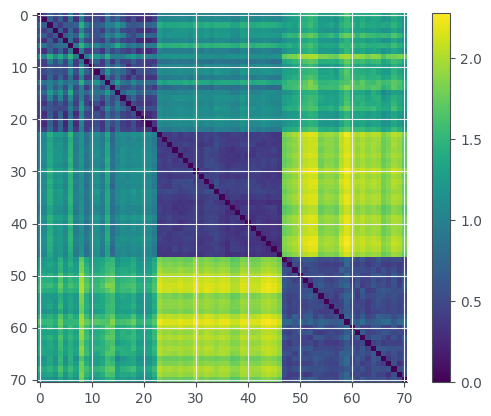

In [181]:
from scipy.spatial import distance

m1 = distance.cdist(templates, templates, 'euclidean')

plt.imshow(m1)
plt.colorbar()
plt.show()

In [182]:
m1.shape

(71, 71)

In [184]:
d = []
for u in users:
  d = np.hstack((d,m1[labels==u][:,labels==u].flatten()))
d.shape

(1681,)

In [183]:
d2 = []
for u in users:
  d2 = np.hstack((d2,m1[labels==u][:,labels!=u].flatten()))
d2.shape

(3360,)

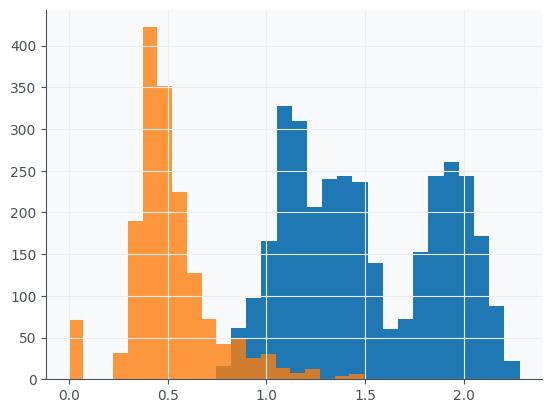

In [160]:
plt.hist(d2, bins=20)
plt.hist(d, bins=20, alpha=0.8)
plt.show();


In [166]:
counts, bins = np.histogram(m[labels==2])
plt.hist(bins[:-1], bins, weights=counts)
plt.show();

IndexError: boolean index did not match indexed array along dimension 0; dimension is 35 but corresponding boolean dimension is 71

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(templates, labels, test_size=0.5, random_state=42)
y_train[y_train != 1] = 0
y_test[y_test != 1] = 0

In [112]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
neigh = neigh.fit(X_train, y_train)

In [113]:
y_pred = neigh.predict(X_test)

In [114]:
y_pred

array([1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0.])

In [117]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[24,  0],
       [ 1, 11]])

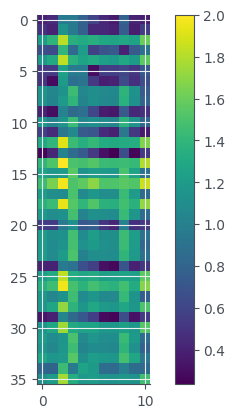

In [197]:
m = distance.cdist(X_test, X_train[y_train==1], 'euclidean')

plt.imshow(m)
plt.colorbar()
plt.show()

In [196]:
d1 = []
d0 = []
print(m.shape)
for z in [0,1]:
  d1 = np.hstack((d1,m[y_train==z][:,y_test==z].flatten()))
  d0 = np.hstack((d1,m[y_train==z][:,y_test!=z].flatten()))

plt.hist(d1, bins=20)
plt.hist(d0, bins=20, alpha=0.8)
plt.show();

(11, 36)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 35

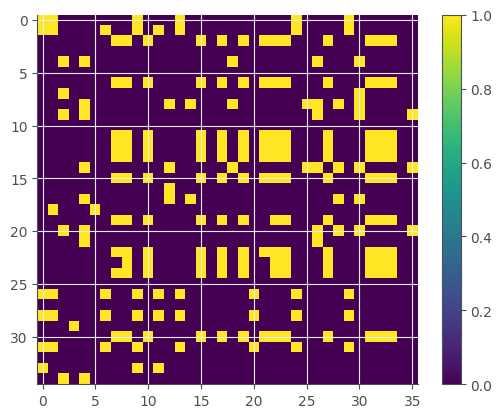

In [159]:
plt.imshow(m < 0.5)
plt.colorbar()
plt.show()

In [157]:
pred = np.min(m, axis =0)
print(pred)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred < .37)

[0.35969934 0.36914627 0.4230088  0.4106809  0.39425988 0.29229456
 0.2850189  0.37559329 0.28550528 0.30129851 0.35228593 0.3658152
 0.42821583 0.23541524 0.39910123 0.40211386 0.60795058 0.34330277
 0.47275101 0.31763633 0.42419633 0.37884569 0.29379058 0.34478839
 0.272453   0.43841832 0.44052204 0.31832747 0.36263318 0.26872296
 0.39156644 0.30307119 0.34524526 0.30877181 0.80444386 0.44754379]


array([[13, 11],
       [ 3,  9]])